<a href="https://colab.research.google.com/github/prachuryanath/TF-Learning/blob/main/03_convolutional_neural_networks_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks and Computer Vision
Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self-driving car recognizing the car in front.
The images we're working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

However we've modified it to only use two classes (pizza 🍕 & steak 🥩) using the image data modification notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb




In [5]:
import zipfile

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the download file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2021-05-13 08:56:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 142.250.13.128, 142.250.110.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109579078 (105M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.50M   122MB/s    in 0.9s    

2021-05-13 08:56:24 (122 MB/s) - ‘pizza_steak.zip’ saved [109579078/109579078]



## Inspect the data (Become one with it)

In [6]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 1 images in 'pizza_steak'.
There are 2 directories and 1 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.
There are 2 directories and 1 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.


In [7]:
!ls pizza_steak

test  train


In [8]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train

750

In [9]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['.DS_Store' 'pizza' 'steak']


In [10]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def view_random_image(target_dir, target_class):
    # Setup target directory (we'llview images from here)
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}")  # Show the shape of the image

    return img

Image shape: (382, 512, 3)


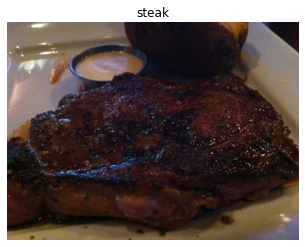

In [11]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

In [12]:
# The images we've imported and plotted are actually giant arrays/tensors of different pixel values
import tensorflow as tf
tf.constant(img)

<tf.Tensor: shape=(382, 512, 3), dtype=uint8, numpy=
array([[[128, 116, 120],
        [127, 115, 119],
        [127, 114, 121],
        ...,
        [ 21,  14,  22],
        [ 21,  14,  22],
        [ 23,  16,  24]],

       [[125, 113, 117],
        [127, 115, 119],
        [128, 116, 120],
        ...,
        [ 19,  12,  20],
        [ 18,  11,  19],
        [ 20,  13,  21]],

       [[121, 109, 113],
        [124, 112, 116],
        [127, 115, 119],
        ...,
        [ 19,  12,  20],
        [ 18,  11,  19],
        [ 19,  12,  20]],

       ...,

       [[169, 133,  81],
        [165, 129,  77],
        [164, 128,  78],
        ...,
        [ 92,  86, 100],
        [ 98,  92, 104],
        [102,  96, 108]],

       [[171, 134,  82],
        [165, 128,  76],
        [164, 126,  77],
        ...,
        [ 94,  86,  99],
        [ 97,  89, 100],
        [ 95,  87,  98]],

       [[172, 132,  81],
        [164, 124,  73],
        [164, 124,  75],
        ...,
        [101,  91, 10

In [13]:
# View the image shape
img.shape       # return (width,height, color channels)

(382, 512, 3)

In [14]:
# Get all the pixel values between 0 & 1
img/255.

array([[[0.50196078, 0.45490196, 0.47058824],
        [0.49803922, 0.45098039, 0.46666667],
        [0.49803922, 0.44705882, 0.4745098 ],
        ...,
        [0.08235294, 0.05490196, 0.08627451],
        [0.08235294, 0.05490196, 0.08627451],
        [0.09019608, 0.0627451 , 0.09411765]],

       [[0.49019608, 0.44313725, 0.45882353],
        [0.49803922, 0.45098039, 0.46666667],
        [0.50196078, 0.45490196, 0.47058824],
        ...,
        [0.0745098 , 0.04705882, 0.07843137],
        [0.07058824, 0.04313725, 0.0745098 ],
        [0.07843137, 0.05098039, 0.08235294]],

       [[0.4745098 , 0.42745098, 0.44313725],
        [0.48627451, 0.43921569, 0.45490196],
        [0.49803922, 0.45098039, 0.46666667],
        ...,
        [0.0745098 , 0.04705882, 0.07843137],
        [0.07058824, 0.04313725, 0.0745098 ],
        [0.0745098 , 0.04705882, 0.07843137]],

       ...,

       [[0.6627451 , 0.52156863, 0.31764706],
        [0.64705882, 0.50588235, 0.30196078],
        [0.64313725, 0

## An end-to-end example
Let's build a convolutional neural network to find patterns in our images, more specifically we a need way to:

* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2,
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 43s 271ms/step - loss: 0.6094 - accuracy: 0.6502 - val_loss: 0.5310 - val_accuracy: 0.7000
Epoch 2/5
47/47 [==============================] - 11s 231ms/step - loss: 0.4776 - accuracy: 0.7472 - val_loss: 0.3514 - val_accuracy: 0.8500
Epoch 3/5
47/47 [==============================] - 11s 232ms/step - loss: 0.4250 - accuracy: 0.8064 - val_loss: 0.3252 - val_accuracy: 0.8560
Epoch 4/5
47/47 [==============================] - 11s 232ms/step - loss: 0.3425 - accuracy: 0.8527 - val_loss: 0.3227 - val_accuracy: 0.8660
Epoch 5/5
47/47 [==============================] - 11s 238ms/step - loss: 0.3238 - accuracy: 0.8620 - val_loss: 0.3231 - val_accuracy: 0.8700


In [16]:
# Get a model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

## Using the same model as before

Let's replicate the model we've built in the previous section to see if it works with our image data

In [17]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")                         
])

# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 11s 214ms/step - loss: 2.1354 - accuracy: 0.5136 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 10s 205ms/step - loss: 0.6931 - accuracy: 0.5070 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 10s 204ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 10s 207ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 10s 209ms/step - loss: 0.6933 - accuracy: 0.4867 - val_loss: 0.6931 - val_accuracy: 0.5000


In [18]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Despite having 20x more parameters than our CNN model(model_1), model_2 performs terribly, let's try to improve it.

In [19]:
# Set the random seed
tf.random.set_seed(42)

# Create the model (same as above but let's step it up a notch)
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")                            
])

# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 11s 220ms/step - loss: 5.6880 - accuracy: 0.5380 - val_loss: 0.6473 - val_accuracy: 0.7560
Epoch 2/5
47/47 [==============================] - 10s 208ms/step - loss: 0.6876 - accuracy: 0.7386 - val_loss: 0.8530 - val_accuracy: 0.5900
Epoch 3/5
47/47 [==============================] - 10s 208ms/step - loss: 0.7118 - accuracy: 0.7185 - val_loss: 1.2699 - val_accuracy: 0.5580
Epoch 4/5
47/47 [==============================] - 10s 207ms/step - loss: 0.8914 - accuracy: 0.7236 - val_loss: 0.4479 - val_accuracy: 0.7980
Epoch 5/5
47/47 [==============================] - 10s 207ms/step - loss: 0.5595 - accuracy: 0.7465 - val_loss: 0.7818 - val_accuracy: 0.7500


In [20]:
# Check the model_3 architecture
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15052900  
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


My gosh, the number of trainable parameters has increased even more than model_2. And even with close to 500x (~15,000,000 vs. ~31,000) more trainable parameters, model_3 still doesn't out perform model_1.

This goes to show the power of convolutional neural networks and their ability to learn patterns despite using less parameters.

## **Binary Classification: Let's break it down**

1. Become one with the data (visualize, visualize, visualize)
2. Preprocess the data (prepared it for our model, the main step here was scaling/normalizing & turning our data into batches)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve the model (try to beat our baseline)
7. Repeat until satisfied (experiment, experiment, experiment)

### **1. Become one with the data**

Image shape: (384, 512, 3)
Image shape: (382, 512, 3)


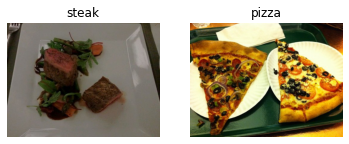

In [21]:
# Visualize data
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1,2,2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

### **2. Preprocess the data (prepare it for a model)**

In [22]:
# Define directory dataset paths
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

Our next step is to turn our data into batches.

A batch is a small subset of data. Rather than look at all ~10,000 images at one time, a model might only look at 32 at a time.

It does this for a couple of reasons:

10,000 images (or more) might not fit into the memory of your processor (GPU).
Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

In [23]:
# Create train and test data generators and rescale the data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [24]:
# Load in our image data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, # Target directoy of images
                                               target_size=(224, 224), # Target size of images (height, width)
                                               class_mode="binary", # type of data you're working with
                                               batch_size=32) # size of minibatches to load data into

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             class_mode="binary",
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [25]:
# Get a sample of a train data batch
images, labels = train_data.next() # get the "next" batch of images/labels in train_data
len(images), len(labels)

(32, 32)

In [26]:
# How many batches are there ?
len(train_data)

47

In [27]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.4784314 , 0.427451  , 0.3647059 ],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.8313726 , 0.70980394, 0.48627454],
          [0.8431373 , 0.73333335, 0.5372549 ],
          [0.87843144, 0.7725491 , 0.5882353 ]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.5058824 ],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.49411768],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.78039

In [28]:
# View the first batch of labels
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

### **3. Create a model (start with a baseline)**

In [29]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [30]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_4 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

Let's discuss some of the components of the Conv2D layer:

* The "2D" means our inputs are two
dimensional (height and width), even though they have 3 colour channels, the convolutions are run on each channel invididually.
* filters - these are the number of "feature extractors" that will be moving over our images.
* kernel_size - the size of our filters, for example, a kernel_size of (3, 3) (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.
* stride - the number of pixels a filter will move across as it covers the image. A stride of 1 means the filter moves across each pixel 1 by 1. A stride of 2 means it moves 2 pixels at a time.
* padding - this can be either 'same' or 'valid', 'same' adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as 'valid' (default) cuts off excess pixels where the filter doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.

In [31]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [32]:
# Get a summary of our model
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 475240)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


### **4. Fit the model**

In [33]:
# Check the lengths of training and test data generators
len(train_data), len(test_data)

(47, 16)

You'll notice two new parameters here:

* steps_per_epoch - this is the number of batches a model will go through per epoch, in our case, we want our model to go through all batches so it's equal to the length of train_data (1500 images in batches of 32 = 1500/32 = ~47 steps)
* validation_steps - same as above, except for the validation_data parameter (500 test images in batches of 32 = 500/32 = ~16 steps)


In [34]:
# Fit the model
history_4 = model_4.fit(train_data, # this is a combination of labels and sample data
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 13s 256ms/step - loss: 2.4861 - accuracy: 0.5732 - val_loss: 0.4691 - val_accuracy: 0.7880
Epoch 2/5
47/47 [==============================] - 11s 236ms/step - loss: 0.4484 - accuracy: 0.8086 - val_loss: 0.4111 - val_accuracy: 0.8060
Epoch 3/5
47/47 [==============================] - 11s 237ms/step - loss: 0.3545 - accuracy: 0.8476 - val_loss: 0.3810 - val_accuracy: 0.8260
Epoch 4/5
47/47 [==============================] - 11s 236ms/step - loss: 0.1922 - accuracy: 0.9440 - val_loss: 0.4799 - val_accuracy: 0.8000
Epoch 5/5
47/47 [==============================] - 11s 237ms/step - loss: 0.0766 - accuracy: 0.9796 - val_loss: 0.6217 - val_accuracy: 0.7740


### **5. Evaluating our model**

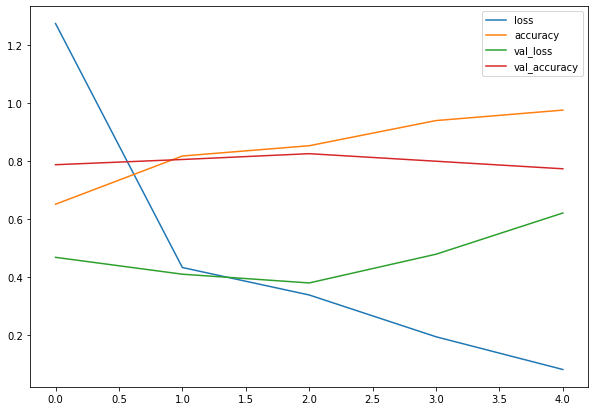

In [35]:
# Let's plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

In [36]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs did we run for?

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

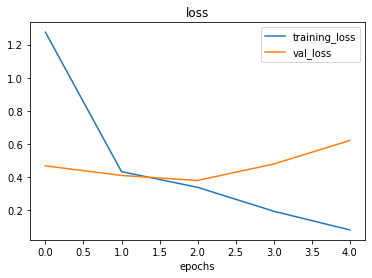

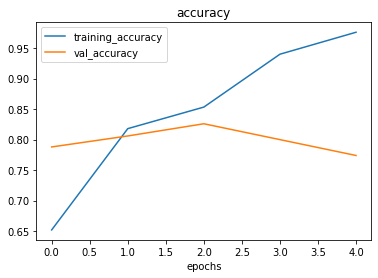

In [37]:
# Check out the loss and accuracy of model_4
plot_loss_curves(history_4)

### **6. Adjust the model parameters**
Fitting a machine learning model comes in 3 steps:
1. Create a baseline
2. Beat the baseline by overfitting a larger model
3. Reduce overfitting

Ways to induce overfitting:
* Increase the number of conv layers
* Increase the number of conv filters
* Add another dense layer to the output of our flattened layer

Reduce overfitting:
* Add data augmentation
* Add regularization layers (such as MaxPool2D)
* Add more data...

In [38]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

Woah, we've got another layer type we haven't seen before.

If convolutional layers learn the features of an image you can think of a Max Pooling layer as figuring out the most important of those features. We'll see this an example of this in a moment.

In [39]:
# Compile model (same as model_4)
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [40]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 11s 224ms/step - loss: 0.6862 - accuracy: 0.5469 - val_loss: 0.5131 - val_accuracy: 0.7400
Epoch 2/5
47/47 [==============================] - 10s 214ms/step - loss: 0.4947 - accuracy: 0.7799 - val_loss: 0.4119 - val_accuracy: 0.8400
Epoch 3/5
47/47 [==============================] - 10s 217ms/step - loss: 0.4457 - accuracy: 0.8120 - val_loss: 0.3765 - val_accuracy: 0.8420
Epoch 4/5
47/47 [==============================] - 10s 215ms/step - loss: 0.4069 - accuracy: 0.8327 - val_loss: 0.3277 - val_accuracy: 0.8720
Epoch 5/5
47/47 [==============================] - 10s 219ms/step - loss: 0.3789 - accuracy: 0.8394 - val_loss: 0.3062 - val_accuracy: 0.8740


In [41]:
# Get a summary of our model with max pooling
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6760)             

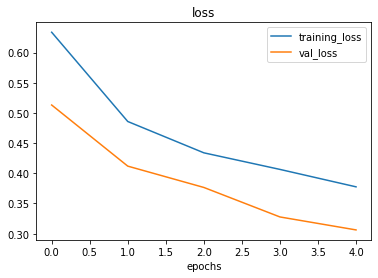

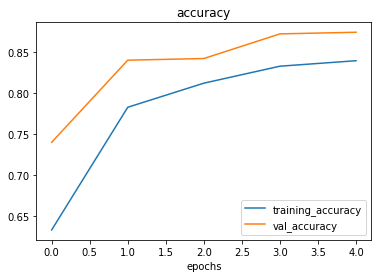

In [42]:
# Plot loss curves
plot_loss_curves(history_5)

**Data Augmentation**

Data augmentation is the process of altering our training data, leading it to have more diversity and in turn allowing our models to learn more generalizable (hopefully) patterns. Altering might mean adjuting the rotation of an image, flipping it, cropping it or something similar.

In [43]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2, # how much do you want to rotate an image?
                                             shear_range=0.2, # how much do you want to shear an image?
                                             zoom_range=0.2, # zoom in randomly on an image
                                             width_shift_range=0.2, # move your iamge around on the x-axis
                                             height_shift_range=0.2, # move your image around on the y-axis
                                             horizontal_flip=True) # do you want to flip and image? 

# Create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator without data augmentation for the test dataset
test_datagen = ImageDataGenerator(rescale=1/255.)

In [44]:
# Import data and augment it from training directory
print("Augmented training data:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode="binary",
                                                                   shuffle=False) # for demonstration purposes only

# Create non-augmented train data batches
print("Non-augmented training data:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="binary",
                                               shuffle=False)

IMG_SIZE = (224, 224)
# Create non-augmented test data batches
print("Non-augmented test data:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SIZE,
                                             batch_size=32,
                                             class_mode="binary")

Augmented training data:
Found 1500 images belonging to 2 classes.
Non-augmented training data:
Found 1500 images belonging to 2 classes.
Non-augmented test data:
Found 500 images belonging to 2 classes.


In [45]:
# Get sample data batches
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # note: labels aren't augmented... only data (images)

showing image number: 4


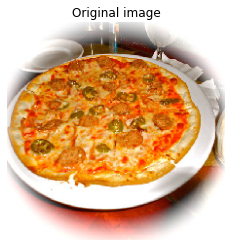

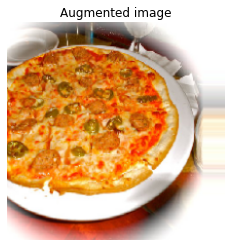

In [46]:
# Show original image and augmented image
import random
random_number = random.randint(0, 32) # our batch sizes are 32...
print(f"showing image number: {random_number}")
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [47]:
# Create the model (same as model_5)
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_6 = model_6.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 27s 556ms/step - loss: 0.7153 - accuracy: 0.4067 - val_loss: 0.6870 - val_accuracy: 0.6280
Epoch 2/5
47/47 [==============================] - 26s 549ms/step - loss: 0.6881 - accuracy: 0.5980 - val_loss: 0.6418 - val_accuracy: 0.6560
Epoch 3/5
47/47 [==============================] - 26s 548ms/step - loss: 0.6876 - accuracy: 0.5974 - val_loss: 0.9019 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 26s 545ms/step - loss: 0.8270 - accuracy: 0.5384 - val_loss: 0.6370 - val_accuracy: 0.7820
Epoch 5/5
47/47 [==============================] - 26s 553ms/step - loss: 0.6545 - accuracy: 0.6892 - val_loss: 0.5616 - val_accuracy: 0.7840


🤔 **Question: Why didn't our model get very good results on the training set to begin with?**

*It's because when we created train_data_augmented we turned off data shuffling using shuffle=False which means our model only sees a batch of a single kind of images at a time.*

*For example, the pizza class gets loaded in first because it's the first class. Thus it's performance is measured on only a single class rather than both classes. The validation data performance improves steadily because it contains shuffled data.*

*Since we only set shuffle=False for demonstration purposes (so we could plot the same augmented and non-augmented image), we can fix this by setting shuffle=True on future data generators.* 


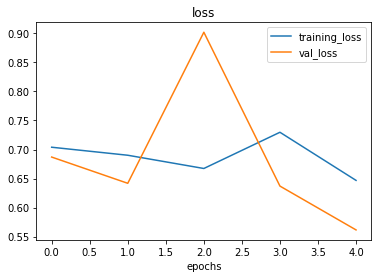

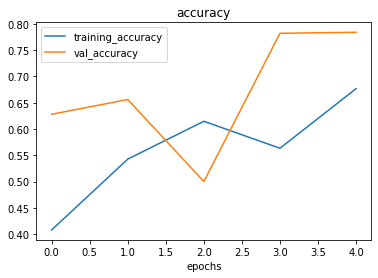

In [48]:
# Check model's performance history training on augmented data
plot_loss_curves(history_6)

In [49]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

Found 1500 images belonging to 2 classes.


In [50]:
# Create the model (same as model_5 and model_6)
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 27s 556ms/step - loss: 0.6769 - accuracy: 0.5778 - val_loss: 0.5957 - val_accuracy: 0.6820
Epoch 2/5
47/47 [==============================] - 26s 547ms/step - loss: 0.6188 - accuracy: 0.6631 - val_loss: 0.4889 - val_accuracy: 0.7300
Epoch 3/5
47/47 [==============================] - 26s 547ms/step - loss: 0.5148 - accuracy: 0.7450 - val_loss: 0.4316 - val_accuracy: 0.7940
Epoch 4/5
47/47 [==============================] - 26s 553ms/step - loss: 0.5399 - accuracy: 0.7290 - val_loss: 0.3344 - val_accuracy: 0.8620
Epoch 5/5
47/47 [==============================] - 26s 553ms/step - loss: 0.4821 - accuracy: 0.7548 - val_loss: 0.3406 - val_accuracy: 0.8560


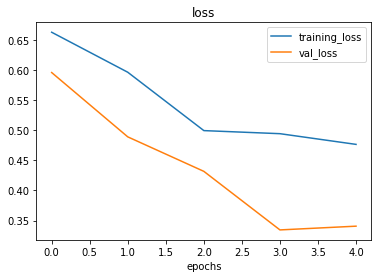

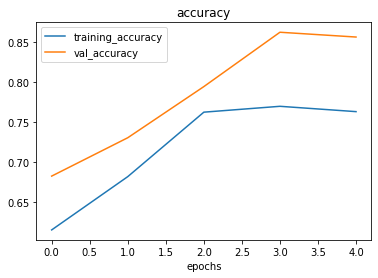

In [51]:
# Plot loss curves
plot_loss_curves(history_7)

### **7. Repeat until satisfied**

*Since we've already beaten our baseline, there are a few things we could try to contine to improve our model:*

* Increase the number of model layers (e.g. add more Conv2D/MaxPool2D layers)
* Increase the number of filters in each convolutional layer (e.g. from 10 to 32 or even 64)
* Train for longer (more epochs)
* Find an ideal learning rate
* Get more data (give the model more opportunities to learn)
* Use **transfer learning** to leverage what another image model has learn and adjust it for our own use case.

In [52]:
# Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_8 = model_8.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 28s 588ms/step - loss: 0.6798 - accuracy: 0.5760 - val_loss: 0.5965 - val_accuracy: 0.6120
Epoch 2/5
47/47 [==============================] - 27s 572ms/step - loss: 0.5791 - accuracy: 0.6965 - val_loss: 0.4375 - val_accuracy: 0.7920
Epoch 3/5
47/47 [==============================] - 27s 573ms/step - loss: 0.5228 - accuracy: 0.7562 - val_loss: 0.4323 - val_accuracy: 0.8180
Epoch 4/5
47/47 [==============================] - 27s 568ms/step - loss: 0.5214 - accuracy: 0.7491 - val_loss: 0.4108 - val_accuracy: 0.8300
Epoch 5/5
47/47 [==============================] - 27s 567ms/step - loss: 0.5534 - accuracy: 0.7269 - val_loss: 0.3818 - val_accuracy: 0.8560


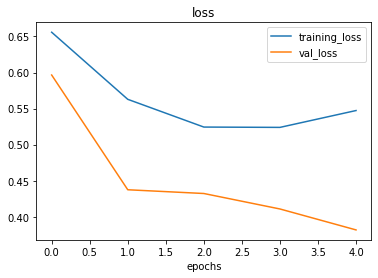

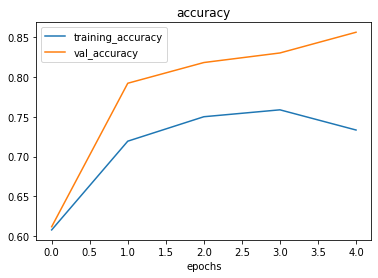

In [53]:
# Check out the TinyVGG model performance
plot_loss_curves(history_8)

### **Making a prediction with our trained model**

In [54]:
# Classes we're working with
print(class_names)

['.DS_Store' 'pizza' 'steak']


--2021-05-13 09:08:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.09s   

2021-05-13 09:08:14 (20.5 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



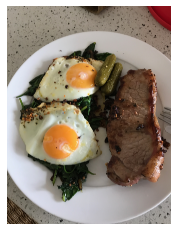

In [55]:
# View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [56]:
# Check the shape of our image
steak.shape

(4032, 3024, 3)

In [57]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into (224,224,3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [58]:
# Load in and preprocess our custom image
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

Well, the batch size becomes the first dimension.

So in reality, our model was trained on data in the shape of (batch_size, 224, 224, 3).

We can fix this by adding an extra to our custom image tensor using tf.expand_dims.

In [59]:
# Add an extra axis
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {steak.shape}")
steak

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.6377451 , 0.6220588 , 0.57892156],
         [0.6504902 , 0.63186276, 0.5897059 ],
         [0.63186276, 0.60833335, 0.5612745 ],
         ...,
         [0.52156866, 0.05098039, 0.09019608],
         [0.49509802, 0.04215686, 0.07058824],
         [0.52843136, 0.07745098, 0.10490196]],

        [[0.6617647 , 0.6460784 , 0.6107843 ],
         [0.6387255 , 0.6230392 , 0.57598037],
         [0.65588236, 0.63235295, 0.5852941 ],
         ...,
         [0.5352941 , 0.06862745, 0.09215686],
         [0.529902  , 0.05931373, 0.09460784],
         [0.5142157 , 0.05539216, 0.08676471]],

        [[0.6519608 , 0.6362745 , 0.5892157 ],
         [0.6392157 , 0.6137255 , 0.56764704],
         [0.65637255, 0.6269608 , 0.5828431 ],
         ...,
         [0.53137255, 0.06470589, 0.08039216],
         [0.527451  , 0.06862745, 0.1       ],
         [0.52254903, 0.05196078, 0.0872549 ]],

        ...,

        [[0.49313724, 0.42745098, 

In [60]:
# Make a prediction on custom image tensor
pred = model_8.predict(steak)
pred

array([[0.74208385]], dtype=float32)

In [61]:
# Remind ourselves of our class names
class_names

array(['.DS_Store', 'pizza', 'steak'], dtype='<U9')

In [62]:
# We can index the predicted class by rounding the prediction probability
pred_round = int(tf.round(pred))
if pred_round == 1:
  pred_class = "STEAK"
else:
  pred_class = "PIZZA"
pred_class

'STEAK'

In [63]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_round = int(tf.round(pred))
  if pred_round == 1:
    pred_class = "STEAK"
  else:
    pred_class = "PIZZA"

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

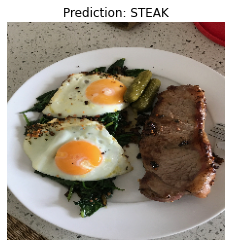

In [64]:
# Test our model on a custom image
pred_and_plot(model_8, "03-steak.jpeg", class_names)

--2021-05-13 09:08:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.07s   

2021-05-13 09:08:17 (38.4 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]



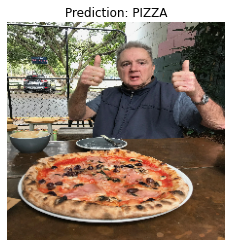

In [65]:
# Download another test image and make a prediction on it
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg 
pred_and_plot(model_8, "03-pizza-dad.jpeg", class_names)

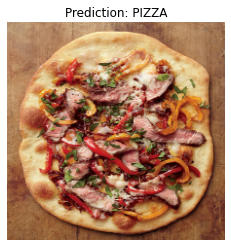

In [66]:
# Download another test image and make a prediction on it
pred_and_plot(model_8, "images/steak-pizza-med107616_vert.jpg", class_names)

## **Multi-Class Classification**

*How about we go through those steps again, except this time, we'll work with 10 different types of food.*

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied

### **1. Import and become one with data**

In [67]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-05-13 09:08:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 64.233.184.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   158MB/s    in 3.1s    

2021-05-13 09:08:21 (158 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [68]:
import os

# Walk through 10 classes of food image data
for dirpath, dirnames, filepath in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 750 images in '10_food_classes_all_data'.
There are 10 directories and 750 images in '10_food_classes_all_data/test'.
There are 0 directories and 750 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/test/ramen'.
There 

In [69]:
# Setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [70]:
# Let's get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (512, 512, 3)


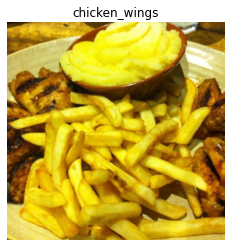

In [71]:
# Visualize, visualize, visualize
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

### **2. Preprocess the data (prepare it for a model)**

In [72]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### **3. Create a model (start with a baseline)**

We can use the same model (TinyVGG) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

Namely:
* Changing the output layer to use have 10 ouput neurons (the same number as the number of classes we have).
* Changing the output layer to use 'softmax' activation instead of 'sigmoid' activation.
* Changing the loss function to be 'categorical_crossentropy' instead of 'binary_crossentropy'.



In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model_9 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_9.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### 4. Fit a model

In [74]:
# Fit the model
history_9 = model_9.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 58s 246ms/step - loss: 2.2889 - accuracy: 0.1421 - val_loss: 2.0218 - val_accuracy: 0.2768
Epoch 2/5
235/235 [==============================] - 55s 235ms/step - loss: 1.9177 - accuracy: 0.3224 - val_loss: 1.9400 - val_accuracy: 0.3072
Epoch 3/5
235/235 [==============================] - 56s 238ms/step - loss: 1.4691 - accuracy: 0.5100 - val_loss: 2.1161 - val_accuracy: 0.2952
Epoch 4/5
235/235 [==============================] - 56s 240ms/step - loss: 0.7981 - accuracy: 0.7584 - val_loss: 2.6286 - val_accuracy: 0.3036
Epoch 5/5
235/235 [==============================] - 56s 240ms/step - loss: 0.2852 - accuracy: 0.9203 - val_loss: 3.8852 - val_accuracy: 0.2804


### 5. Evaluate the model

In [75]:
# Evaluate on the test data
model_9.evaluate(test_data)

79/79 [==============================] - 13s 164ms/step - loss: 3.8852 - accuracy: 0.2804


[3.885201930999756, 0.28040000796318054]

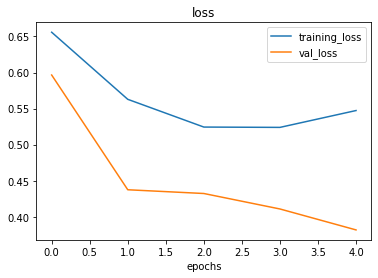

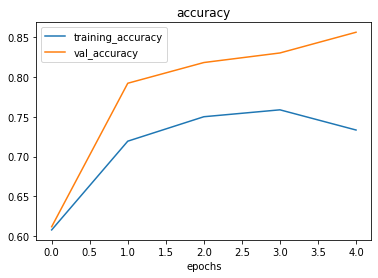

In [76]:
# Check out the model's loss curves on the 10 classes
plot_loss_curves(history_8)

What do these loss curves tell us?

Well... it seems our model is overfitting the training set quite badly... in other words, it's getting great results on the training daa but fails to generalize well to unseen data and performs poorly on the test dataset.

### **6. Adjust the model hyperparameters**
Due to its performance on the training data, it's clear our model is learning something...

However, it's not generalizing well to unseen data (overfitting).

So, let's try and fix overfitting by...
* **Get more data** - having more data gives a model more opportunity to learn diverse patterns...
* **Simpliy the model** - if our current model is overfitting the data, it may be too complicated of a model, one way to simplify a model is to: reduce # of layers or reduce # hidden units in layers
* **Use data augmentation** - data augmentaiton manipulates the training data in such a way to add more diversity to it (without altering the original data)
* **Use transfer learning** - transfer learning leverages the patterns another model has learned on similar data to your own and allows you to use those patterns on your own dataset

In [77]:
# How about we try and simplify the model first?
# Let's try to remove 2 convolutional layers...
model_10 = Sequential([
  Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation="softmax")
])

model_10.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [78]:
# Fit the model with 2x conv layers removed
history_10 = model_10.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 52s 219ms/step - loss: 2.5538 - accuracy: 0.1798 - val_loss: 1.9921 - val_accuracy: 0.2988
Epoch 2/5
235/235 [==============================] - 51s 217ms/step - loss: 1.8497 - accuracy: 0.3631 - val_loss: 1.9629 - val_accuracy: 0.3164
Epoch 3/5
235/235 [==============================] - 51s 217ms/step - loss: 1.4321 - accuracy: 0.5331 - val_loss: 2.0724 - val_accuracy: 0.2896
Epoch 4/5
235/235 [==============================] - 50s 215ms/step - loss: 0.9466 - accuracy: 0.7171 - val_loss: 2.5679 - val_accuracy: 0.2824
Epoch 5/5
235/235 [==============================] - 51s 216ms/step - loss: 0.5428 - accuracy: 0.8431 - val_loss: 2.9064 - val_accuracy: 0.2680


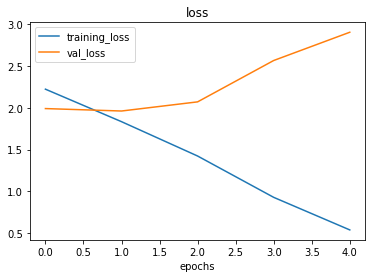

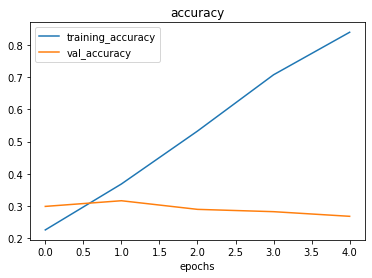

In [79]:
# Check out the loss curves of model_9
plot_loss_curves(history_10)

Looks like our "simplifying the model" experiment didn't work... the accuracy went down and overfitting continued...

How about we try data augmentation??

### **Trying to reduce overfitting with data augmentation**
Let's try and improve our model's results by using augmented training data...

Ideally, we want to:
* Reduce overfitting (get the train and validation loss curves closer)
* Improve validation accuracy

In [80]:
# Create an augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode="categorical")

Found 7500 images belonging to 10 classes.


Rather than rewrite the model from scratch, we can clone it using a handy function in TensorFlow called clone_model which can take an existing model and rebuild it in the same format.

The cloned version will not include any of the weights (patterns) the original model has learned. So when we train it, it'll be like training a model from scratch.

In [81]:
# Clone the model (use the same architecture)
model_11 = tf.keras.models.clone_model(model_10)

# Compile the cloned model (same setup as used for model_10)
model_11.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_11 = model_11.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 127s 540ms/step - loss: 2.3860 - accuracy: 0.1444 - val_loss: 2.0638 - val_accuracy: 0.2616
Epoch 2/5
235/235 [==============================] - 125s 532ms/step - loss: 2.1189 - accuracy: 0.2371 - val_loss: 2.0825 - val_accuracy: 0.2628
Epoch 3/5
235/235 [==============================] - 124s 526ms/step - loss: 2.0359 - accuracy: 0.2826 - val_loss: 1.8179 - val_accuracy: 0.3776
Epoch 4/5
235/235 [==============================] - 124s 529ms/step - loss: 1.9701 - accuracy: 0.3153 - val_loss: 1.8301 - val_accuracy: 0.3764
Epoch 5/5
235/235 [==============================] - 126s 538ms/step - loss: 1.9082 - accuracy: 0.3454 - val_loss: 1.8067 - val_accuracy: 0.3868


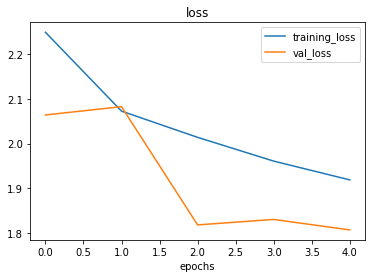

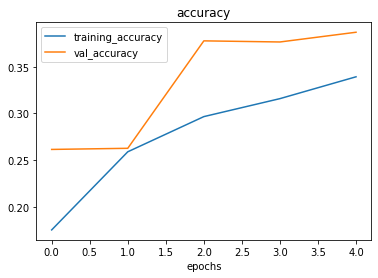

In [82]:
# Check out our model's performance with augmented data
plot_loss_curves(history_11)

### **7. Repeat until satisfied**

We could keep going here. Restructuring our model's architecture, adding more layers, trying it out, adjusting the learning rate, trying it out, trying different methods of data augmentation, training for longer. But as you could image, this could take a fairly long time.

Good thing there's still one trick we haven't tried yet and that's transfer learning which we'll see in the next notebook

**Making a prediction with our trained model**

In [83]:
# What classes has our model been trained on?
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [84]:
# -q is for "quiet"
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

In [85]:
# Reconfig pred_and_plot function to work with multi-class images
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Add in logic for multi-class & get pred_class name
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

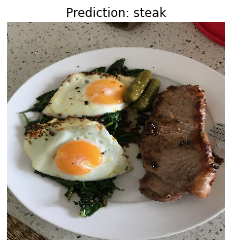

In [86]:
# Make a prediction using model_11
pred_and_plot(model=model_11, 
              filename="03-steak.jpeg", 
              class_names=class_names)

In [86]:
pred_and_plot(model=model_11,
              filename="03-steak.jpeg",
              class_names=class_names)

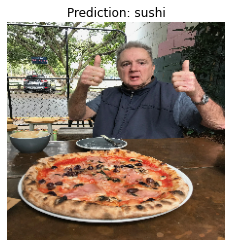

In [87]:
pred_and_plot(model=model_11,
              filename="03-sushi.jpeg",
              class_names=class_names)

In [87]:
# Good news: our updated pred_and_plot function works for binary classification too...
pred_and_plot(model=model_3, # trained on pizza vs. steak
              filename="03-steak.jpeg",
              class_names=["pizza", "steak"])

### Saving and loading our model

Once you've trained a model, you probably want to be able to save it and load it somewhere else.

To do so, we can use the save and load_model functions.

In [88]:
# Save a model
model_11.save("saved_trained_model")

INFO:tensorflow:Assets written to: saved_trained_model/assets


In [89]:
# Load in a model and evaluate it
loaded_model_11 = tf.keras.models.load_model("saved_trained_model")
loaded_model_11.evaluate(test_data)

79/79 [==============================] - 12s 154ms/step - loss: 1.8067 - accuracy: 0.3868


[1.8066935539245605, 0.38679999113082886]

In [90]:
# Compare our unsaved model's results (same as above)
model_11.evaluate(test_data)

79/79 [==============================] - 12s 153ms/step - loss: 1.8067 - accuracy: 0.3868


[1.8066937923431396, 0.38679999113082886]